Optimized weights from PSO: [53.18756018]

Top 15 results for query: car vacuum

Rank 1: ID=12, Score=34.6521
Doc: 0.5 kg 1 Car Vacuum Cleaner 30 x 13 x 10 cm...

Rank 2: ID=457, Score=33.1323
Doc: 0.5 kg 1 Car Vacuum Cleaner 20 x 12 x 12 cm...

Rank 3: ID=75, Score=28.5906
Doc: 14.4 V 4 4 m NO 0 Year Yes Yes 0 Year 700 W(Motor) 0.2 kg No Plastic Foot Operated On/Off Switch 700 W 110 Car Vacuum Cl...

Rank 4: ID=269, Score=25.4060
Doc: No 1 Months Car Cover With Ultra Surface Body Protection 1 Car Cover Yes Car Yes...

Rank 5: ID=157, Score=25.1463
Doc: 12 V No Manufacturing defects Reusable Dust Bag, Anti-Bacterial Cleaning, 2 in 1 Mopping and Vacuum, Ozone Air Purificat...

Rank 6: ID=565, Score=25.0132
Doc: 12 V Yes 1 Reusable Dust Bag 120 W(Motor) 2 kg Foot Operated On/Off Switch 1 Car Upholstery Car Vacuum Cleaner 30 x 14 x...

Rank 7: ID=596, Score=24.4380
Doc: PC Material Large Dust Container, Useful in Dry &amp; Wet Dust 12 V No 4.5 m Parts and Labor 1 Year Dry / Wet Dust Colle

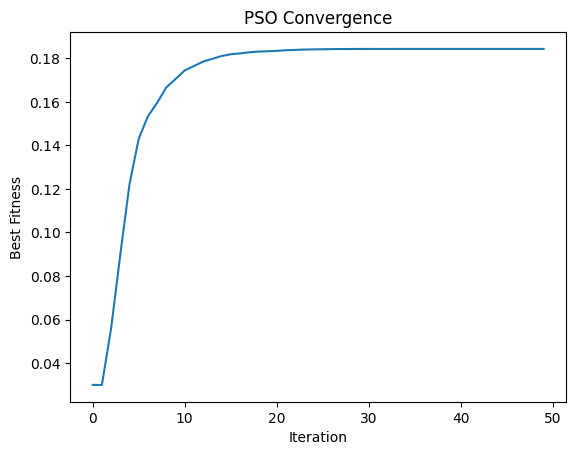

In [6]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# -----------------------------
# Load data.json
# -----------------------------
with open("data-set.json", "r") as f:
    documents = json.load(f)

# Each document: combine all fields except id into a single text
corpus = []
ids = []
for doc in documents:
    ids.append(doc.get("id", "NA"))
    text_parts = [str(v) for k, v in doc.items() if k != "id"]
    corpus.append(" ".join(text_parts))

# -----------------------------
# TF-IDF Setup
# -----------------------------
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# -----------------------------
# Fitness function for PSO
# -----------------------------
def fitness(weights, query):
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Simple weighted score (expandable with other features)
    score = weights[0] * sim_scores
    return np.mean(score)  # maximize mean relevance

# -----------------------------
# Particle Swarm Optimization
# -----------------------------
def pso(query, num_particles=20, max_iter=50, w=0.5, c1=1, c2=2):
    dim = 1  # only one weight here (tf-idf score)
    pos = np.random.uniform(-10, 10, (num_particles, dim))
    vel = np.random.uniform(-1, 1, (num_particles, dim))
    
    pbest = pos.copy()
    pbest_scores = np.array([fitness(p, query) for p in pos])
    
    gbest_idx = np.argmax(pbest_scores)
    gbest = pbest[gbest_idx]
    gbest_score = pbest_scores[gbest_idx]

    history = []
    
    for it in range(max_iter):
        for i in range(num_particles):
            score = fitness(pos[i], query)
            if score > pbest_scores[i]:
                pbest[i] = pos[i]
                pbest_scores[i] = score
        
        gbest_idx = np.argmax(pbest_scores)
        if pbest_scores[gbest_idx] > gbest_score:
            gbest = pbest[gbest_idx]
            gbest_score = pbest_scores[gbest_idx]
        
        # Update velocity and position
        r1, r2 = np.random.rand(), np.random.rand()
        vel = w * vel + c1 * r1 * (pbest - pos) + c2 * r2 * (gbest - pos)
        pos = pos + vel

        history.append(gbest_score)
    
    return gbest, history

# -----------------------------
# Rank documents using optimized weights
# -----------------------------
def rank(query, weights, top_k=15):
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    final_scores = weights[0] * sim_scores
    
    ranked = sorted(zip(ids, final_scores, corpus), key=lambda x: x[1], reverse=True)
    return ranked[:top_k]

# -----------------------------
# Example Run
# -----------------------------
query = "car vacuum"
best_weights, history = pso(query)

print("Optimized weights from PSO:", best_weights)

results = rank(query, best_weights, top_k=15)
print(f"\nTop {len(results)} results for query: {query}\n")
for rank_id, (doc_id, score, doc_text) in enumerate(results, 1):
    print(f"Rank {rank_id}: ID={doc_id}, Score={score:.4f}")
    print(f"Doc: {doc_text[:120]}...\n")  # show only first 120 chars

# Plot PSO convergence
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("PSO Convergence")
plt.show()
